In [1]:
from LinearTrainer import GridSearcher
from LinearTrainer import LinearTrainer
import torch
torch.set_float32_matmul_precision('high')

In [2]:
from datasets.utils_datasets import get_mnist_binary_static_loaders
seed = 5
loaders =  get_mnist_binary_static_loaders(seed=seed, batch_size_train=256)

In [3]:
gr = GridSearcher(loaders)

In [4]:
path = 'experiment_1'

In [ ]:
gr.conduct_experiment(path=path)

In [5]:
betas = gr.betas

In [6]:
import pandas as pd

# BETA

In [7]:
df_beta_vae : pd.DataFrame = pd.read_csv(f'{path}/beta_vae.csv', index_col=0)

In [8]:
df_beta_vae = df_beta_vae.reset_index(drop=True)
df_beta_vae.head()

,use_multi_rate,mean_loss,beta,lr
0,False,2299.362111,0.010000,0.010
1,False,2381.261432,0.010000,0.003
2,False,2989.150078,0.010000,0.001
3,False,2299.362111,0.021544,0.010
4,False,2381.261432,0.021544,0.003


In [9]:
# select the best for beta 
df_beta_vae_sorted = []
for name, group in df_beta_vae.groupby('beta'):
    lr = group.sort_values(by='mean_loss').reset_index().at[0, 'lr']
    df_beta_vae_sorted.append({'beta': name, 'lr': lr})
    print(f'beta={name}, lr={lr}')
df_beta_vae_sorted = pd.DataFrame(df_beta_vae_sorted)

beta=0.01, lr=0.01
beta=0.0215443469003188, lr=0.01
beta=0.0464158883361278, lr=0.01
beta=0.1, lr=0.01
beta=0.2154434690031884, lr=0.01
beta=0.4641588833612781, lr=0.01
beta=1.0, lr=0.01
beta=2.154434690031884, lr=0.01
beta=4.641588833612779, lr=0.01
beta=10.000000000000002, lr=0.01


In [10]:
import torch
torch.manual_seed(1)
rec_beta_vae = []
distortion_beta_vae = []
for i in range(0, len(df_beta_vae_sorted)):
    beta = df_beta_vae_sorted.at[i, 'beta']
    lr = df_beta_vae_sorted.at[i, 'lr']
    print(f'best learning rate for beta: {beta} is lr: {lr}\n')
    trainer = LinearTrainer(loaders, use_multi_rate=False, beta=beta, lr=lr)
    trainer.train()
    _, (rec_losses, kdl_losses) = trainer.rate_distortion_curve_value(beta, beta)
    rec_beta_vae.append(rec_losses)
    distortion_beta_vae.append(kdl_losses)


best learning rate for beta: 0.01 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 0.0215443469003188 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 0.0464158883361278 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 0.1 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 0.2154434690031884 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 0.4641588833612781 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 1.0 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 2.154434690031884 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 4.641588833612779 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

best learning rate for beta: 10.000000000000002 is lr: 0.01



  0%|          | 0/20 [00:00<?, ?it/s]

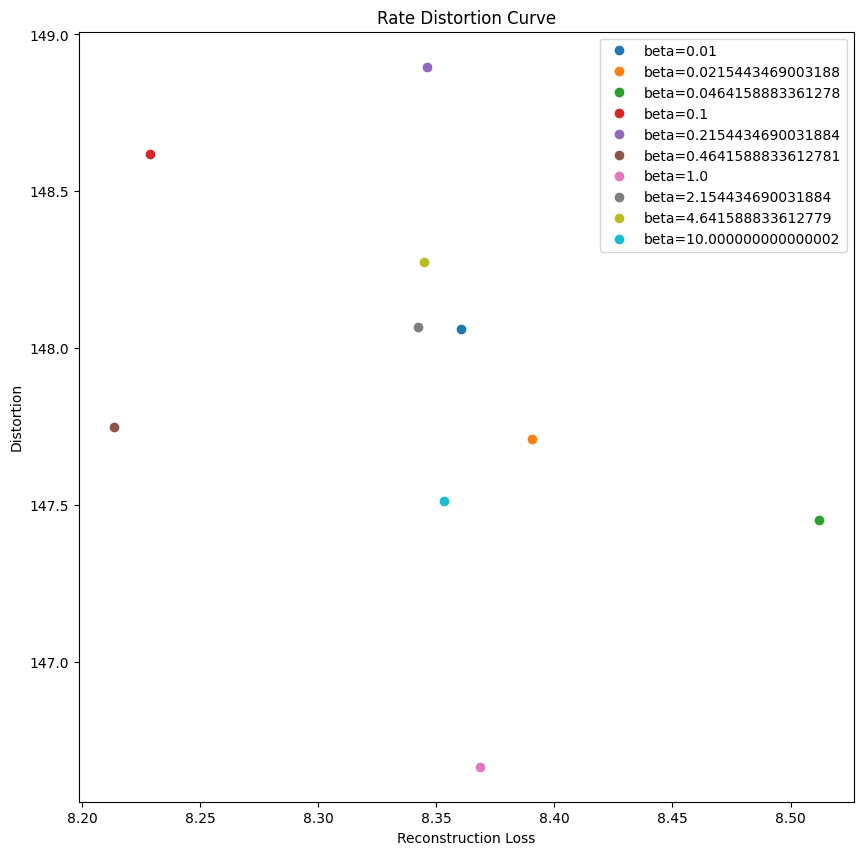

In [11]:
import matplotlib.pyplot as plt
# plot the rate distortion curve
fig = plt.figure(figsize=(10, 10))
for i in range(0, len(df_beta_vae_sorted)):
    beta = df_beta_vae_sorted.at[i, 'beta']
    plt.plot(rec_beta_vae[i], distortion_beta_vae[i], 'o', label=f'beta={beta}')
plt.legend()
plt.xlabel('Reconstruction Loss')
plt.ylabel('Distortion')
plt.title('Rate Distortion Curve')
plt.show()


# MULTI-RATE VAE

In [ ]:
df_multi_rate : pd.DataFrame = pd.read_csv(f'{path}/mr_vae.csv', index_col=0)


In [ ]:
df_multi_rate.head()

In [ ]:
best_lr = df_multi_rate.sort_values(by=['mean_loss']).at[0, 'lr']
print(f'best lr for multi-rate vae  is {best_lr}')

In [ ]:
rec_mr_vae = []
distortion_mr_vae = []
for b in betas:
    trainer = LinearTrainer(loaders, use_multi_rate=True, lr=best_lr)
    trainer.train()
    _, (rec_losses, kdl_losses) = trainer.rate_distortion_curve_value(b, 1.)
    rec_mr_vae.append(rec_losses)
    distortion_mr_vae.append(kdl_losses)